## 20200923-181126-network-RMSprop

In [1]:
import tensorflow as tf
import numpy as np
import sys
sys.path.append('../../')
import utils.data_preprocess as preprocess
from utils.model_metrics import ModelMetric
from utils.mode_figure import ModelFigre
import datetime
from utils.model_callback import step_decay, exp_decay, MyStopTrainCallBack

In [2]:
# my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
# tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')
# # To find out which devices your operations and tensors are assigned to
# tf.debugging.set_log_device_placement(True)
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
modelmetric = ModelMetric()

In [4]:
pre = preprocess.preprocess("D:/DataSet/CICIDS2017/CSV/Wednesday-workingHours.pcap_ISCX.csv", labelColumnName='Label', depth=2)
X_train, X_test, y_train, y_test = pre.preprocessing()
X_train = tf.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = tf.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [5]:
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, GaussianNoise, Flatten, Dense, Input, Activation
from tensorflow.keras import Model
dos_input = Input(shape=(1, X_train.shape[2]))
forward_layer_one = LSTM(64, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=4) , recurrent_constraint=tf.keras.constraints.MaxNorm(max_value=4), return_sequences=True)
backward_layer_one = LSTM(64, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=4) , recurrent_constraint=tf.keras.constraints.MaxNorm(max_value=4), return_sequences=True , go_backwards=True)
bi_one = Bidirectional(forward_layer_one, backward_layer=backward_layer_one, name='bi_one')(dos_input)

noise_one = GaussianNoise(0.5)(bi_one)

bn_one = BatchNormalization()(noise_one)

forward_layer_two = LSTM(32, return_sequences=True)
backward_layer_two = LSTM(32, return_sequences=True, go_backwards=True)
bi_two = Bidirectional(forward_layer_two, backward_layer=backward_layer_two, name='bi_two')(bn_one)

bn_two = BatchNormalization()(bi_two)

forward_layer_three = LSTM(16,)
backward_layer_three = LSTM(16, go_backwards=True)
bi_three = Bidirectional(forward_layer_three, backward_layer=backward_layer_three, name='bi_three')(bn_two)

bn_three = BatchNormalization()(bi_three)

flatten_one = Flatten()(bn_three)

dense_four = Dense(16, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=4), name='dense_three')(flatten_one)
noise_two = GaussianNoise(0.5)(dense_four)
avtivation_four = Activation(tf.nn.relu6, name='dense_four_activation')(noise_two)

bn_four = BatchNormalization()(avtivation_four)

dense = Dense(2, name='classification')(bn_four)
output_res = Activation(tf.nn.softmax, name='classifi')(dense)

model = Model(inputs=dos_input, outputs=output_res)

algorithm = tf.keras.optimizers.RMSprop(learning_rate=0.00125, rho=0.9, clipnorm=0.9, momentum=0.9, epsilon=1e-07, decay= 1e-07, centered=False, name='RMSprop')
# algorithm = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.99, clipvalue=0.2, nesterov=True, name='SGD') # 

model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=modelmetric.metric('binary_crossentropy')) # categorical_crossentropycategorical_crossentropy

In [6]:
from tensorflow.keras import callbacks
dir_name = datetime.datetime.now().strftime("CPU-Best-%Y%m%d-%H%M%S-RMSprop")

logdir = os.path.join("../../tensorboard", dir_name)
tensorboard_callback = callbacks.TensorBoard(logdir, histogram_freq=1)
# lrate = callbacks.LearningRateScheduler(step_decay)
csv_log = tf.keras.callbacks.CSVLogger('../../model_record/CPU/'+dir_name+"/log", separator=',', append=False)
if not os.path.isdir('../../model_record/CPU/'+dir_name):
    os.mkdir('../../model_record/CPU/'+dir_name)
    os.mkdir('../../model_record/CPU/'+dir_name+'/model')
# stop_train = MyStopTrainCallBack()
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [7]:
import numpy as np
model_ = model.fit(X_train, y_train, epochs=150, batch_size=512, validation_split=0.3, callbacks=[tensorboard_callback, csv_log], verbose=1) # lrate, callback

n: 8052.0000 - acc: 0.0000e+00 - precision: 0.9762 - recall: 0.9762 - auc: 0.9967 - binary_accuracy: 0.9762 - binary_crossentropy: 0.0664 - val_loss: 0.0577 - val_tp: 142183.0000 - val_fp: 3013.0000 - val_tn: 142183.0000 - val_fn: 3013.0000 - val_acc: 0.0000e+00 - val_precision: 0.9792 - val_recall: 0.9792 - val_auc: 0.9973 - val_binary_accuracy: 0.9792 - val_binary_crossentropy: 0.0577
Epoch 114/150
662/662 [==============================] - 7s 11ms/step - loss: 0.0666 - tp: 330664.0000 - fp: 8124.0000 - tn: 330664.0000 - fn: 8124.0000 - acc: 0.0000e+00 - precision: 0.9760 - recall: 0.9760 - auc: 0.9967 - binary_accuracy: 0.9760 - binary_crossentropy: 0.0666 - val_loss: 0.0550 - val_tp: 142534.0000 - val_fp: 2662.0000 - val_tn: 142534.0000 - val_fn: 2662.0000 - val_acc: 0.0000e+00 - val_precision: 0.9817 - val_recall: 0.9817 - val_auc: 0.9972 - val_binary_accuracy: 0.9817 - val_binary_crossentropy: 0.0550
Epoch 115/150
662/662 [==============================] - 7s 11ms/step - loss: 0.

In [8]:
results  = model.evaluate(X_test, y_test, verbose=1)
modelmetric.getTrainMetricValue(model, results)

6482/6482 [==============================] - 13s 2ms/step - loss: 0.0529 - tp: 203467.0000 - fp: 3955.0000 - tn: 203467.0000 - fn: 3955.0000 - acc: 0.0000e+00 - precision: 0.9809 - recall: 0.9809 - auc: 0.9974 - binary_accuracy: 0.9809 - binary_crossentropy: 0.0529
loss :  0.05289645493030548
tp :  203467.0
fp :  3955.0
tn :  203467.0
fn :  3955.0
acc :  0.0
precision :  0.9809325933456421
recall :  0.9809325933456421
auc :  0.9974462389945984
binary_accuracy :  0.9809325933456421
binary_crossentropy :  0.05289645493030548


In [9]:
y_pred = model.predict(X_test)
y_class = np.argmax(y_pred, axis=1)
y_label = np.argmax(y_test, axis=1)
modelmetric.confusion_matrix(y_label, y_class)
modelmetric.eva_metric(y_label, y_class)

TrueNegatives result:  128845.0
TruePositives result:  74622.0
FalseNegatives result:  875.0
FalsePositives result:  3080.0
Recall result:  0.9884101
Precision result:  0.96036136


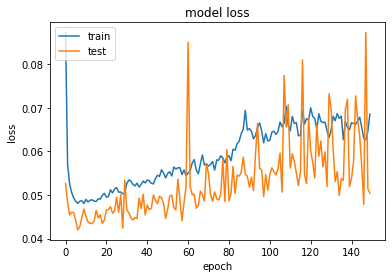

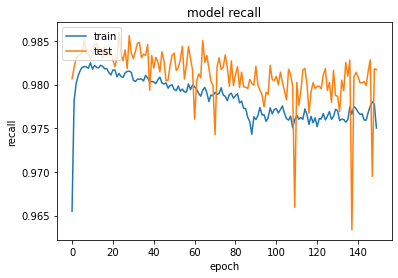

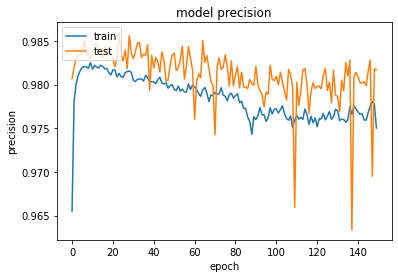

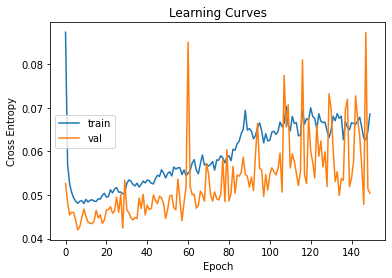

In [10]:
mf = ModelFigre("../../model_record/CPU/", dir_name, model_)
mf.loss_graph()
mf.recall_graph()
mf.precision_graph()
mf.cross_entropy_graph()
# fig.save_model(net,dir_name)

In [11]:
# mf.lr_graph()

In [12]:
model.save('../../model_record/CPU/'+dir_name+'/model/model.h5')